<a href="https://colab.research.google.com/github/astroChance/MPnet/blob/master/DCGAN_Model_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow Tutorial GAN

In [ ]:
##############
## Basic starting point from Tensorflow tutorial for DCGAN

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import segyio
import os
import PIL
from tensorflow.keras import layers
import time

In [ ]:
## Get seismic images



# mnist example
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
# Shuffle data and create batches

buf_size = None  # should be a number equal to or greater than dataset
batch_size = None  # possibly start with 16?

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buf_size).batch(batch_size)

In [ ]:
"""
Model follow-ups:

This workbook persues images (i.e. spectrograms), could move to 1D convolutions and RNN / LSTM
and use trace data as input

"""

In [ ]:
# Define model architectures (initial example assumes 28x28 image)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model



def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Define loss and optimizers

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
# Checkpoint creation

checkpoint_dir = ''   # Drive directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Define training loop


seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

    # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [ ]:
# Restore a previous checkpoint

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Train the model

EPOCHS = 200
noise_dim = 100

train(train_dataset, EPOCHS)

# Garcia SREZ

In [ ]:
## Attempt the Garcia super res model using Keras

# Discriminator:  Conv2D, 64 units, stride 2
#                 batch norm
#                 relu                  

#                 repeat with 128, 256, 512 units

#                 conv2D, 512 units, stride 1
#                 batch norm, relu
#                 repeat

#                 model ends by taking mean? 

# Generator:      Residual block, 256 units
#                 Upscale (2x, nearest neighbor)
#                 batch norm
#                 relu
#                 conv2D transpose, 256 units, stride 1

#                 repeat with 128 units

#                 conv2D, 96 units, stride 1
#                 relu
#                 repeat

#                 conv2D, units=channels (color chans?)
#                 sigmoid

# Discriminator loss:  sigmoid_cross_entropy_with_logits
# Generator loss:  sigmoid_cross_entropy_with_logits

# Optimizer: Adam

In [ ]:
import tensorflow as tf
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU, ReLU
# from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.models import Sequential

print("Tensorflow version: ", tf.__version__)

# !pip install  PIL
from PIL import Image

Tensorflow version:  2.2.0


In [ ]:
"""
Model architectures
"""

# noise_dim = 100    # taken from other examples
# weight_initializer = RandomNormal(0, 0.02)    # taken from other examples



#Make residual block for use in generator
def residual_block(y, nb_channels):    
  x = y.add(Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same'))
  x = y.add(BatchNormalization())
  x = y.add(LeakyReLU())

  x = y.add(Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same'))
  x = y.add(BatchNormalization())
  x = y.add(LeakyReLU())

  return x


# Create generator architecture
def create_generator():
  generator = Sequential()
  
  units = [256, 128, 96]
  upscale_factor_list = [2, 2]

  ### Res Section 1
  residual_block(generator, units[0])
  residual_block(generator, units[0])
  generator.add(layers.UpSampling3D(size=upscale_factor_list[0]))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  generator.add(Conv2DTranspose(units[0], kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))

  ### Res Section 2
  residual_block(generator, units[1])
  residual_block(generator, units[1])
  generator.add(layers.UpSampling3D(size=upscale_factor_list[1]))
  generator.add(BatchNormalization())
  generator.add(ReLU())
  generator.add(Conv2DTranspose(units[1], kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))

  ### Conv Section 3
  generator.add(Conv2D(units[2], kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
  generator.add(ReLU())
  generator.add(Conv2D(units[2], kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False))
  generator.add(ReLU())

  ### Sigmoid Section 4    # why sigmoid layer in generator?
  generator.add(Conv2D(units[2], kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False))
  # generator.add(Dense(1, activation='sigmoid'))

  return generator

###############################################################

# Create discriminator architecture
def create_descriminator():
  discriminator = Sequential()
  
  units = [256, 128, 96]

  # Conv layer 1
  discriminator.add(Conv2D(units[0], kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
  discriminator.add(BatchNormalization())
  discriminator.add(ReLU())

  # Conv layer 2
  discriminator.add(Conv2D(units[1], kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
  discriminator.add(BatchNormalization())
  discriminator.add(ReLU())

  # Conv layer 3
  discriminator.add(Conv2D(units[2], kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
  discriminator.add(BatchNormalization())
  discriminator.add(ReLU())

  # Conv layer 4
  discriminator.add(Conv2D(units[2], kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
  discriminator.add(BatchNormalization())
  discriminator.add(ReLU())

  # Conv layer 5
  discriminator.add(Conv2D(units[2], kernel_size=(1, 1), strides=(1, 1), padding='same', use_bias=False))
  discriminator.add(BatchNormalization())
  discriminator.add(ReLU())

  # Conv layer 4
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))


  return discriminator

In [ ]:
generator = create_generator()
discriminator = create_descriminator()

In [ ]:
"""
Define losses and optimizers
"""

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
"""
Define training loop
"""

noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

    # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
# Checkpoint creation

checkpoint_dir = ''   # Drive directory
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Shuffle data and create batches

buf_size = None  # should be a number equal to or greater than dataset
BATCH_SIZE = 16  # possibly start with 16?

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buf_size).batch(batch_size)

In [ ]:
# Train the model

EPOCHS = 100

train(train_dataset, EPOCHS)

# Another example

In [ ]:
# link   https://medium.com/analytics-vidhya/implementing-a-gan-in-keras-d6c36bc6ab5f


In [ ]:
import numpy as np

from keras.initializers import RandomNormal
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential

In [ ]:
def create_generator():
  generator = Sequential()
  
  # Starting size
  d = 4
  generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
  generator.add(LeakyReLU(0.2))
  # 4x4x256
  generator.add(Reshape((d, d, 256)))
  
  # 8x8x128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  # 16x16*128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  # 32x32x128
  generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  generator.add(LeakyReLU(0.2))
  
  # 32x32x3
  generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
  
  generator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return generator

###############################################################

def create_descriminator():
  discriminator = Sequential()
  
  discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Flatten())
  discriminator.add(Dropout(0.4))
  discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
  
  discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
  return discriminator

# Cyclegan / Pix2Pix

In [ ]:
#link       https://medium.com/analytics-vidhya/transforming-the-world-into-paintings-with-cyclegan-6748c0b85632

# utilizes Unet generator with skip connections

# pix2pix tutorial (Unet generator example)  https://www.tensorflow.org/tutorials/generative/pix2pix

In [2]:
import tensorflow as tf

import os
import time
import datetime
from matplotlib import pyplot as plt
import numpy as np

from IPython import display
from PIL import Image


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
# data and training parameters

BUFFER_SIZE = 350
BATCH_SIZE = 20
IMG_SIZE0 = 256    # Initial model implementation only works with 256x256 - revisit up/down layers for other sizes
IMG_SIZE1 = 256
OUTPUT_CHANNELS = 3

In [5]:
### Load images and create Tensorflow Dataset


# Iterate through folders, create list of filepaths for images
TwoDImages = []
for root, dirs, files in os.walk("/content/drive/My Drive/MPnet/GAN data/Dev_Testing_Data/2D_dev"):
    for name in files:
        if name.endswith(".png"):
            filename = os.path.join(root, name)
            TwoDImages.append(filename)

ThreeDImages = []
for root, dirs, files in os.walk("/content/drive/My Drive/MPnet/GAN data/Dev_Testing_Data/3D_dev"):
    for name in files:
        if name.endswith(".png"):
            filename = os.path.join(root, name)
            ThreeDImages.append(filename)


            
# Load the png file, cast to tensor
def load(image):
    img = Image.open(image)
    img = np.array(img)
    img=img[:,:,:-1]    # using the -1 index to drop the 4th alpha value from png
    img= tf.cast(img, tf.float32)

    return img

############################
### Test #1
### Create combined Input (3D) and Target (2D) dataset
### (how it's done in the example, but causes dimension error later?)

# def normalize(input_image, target_image):
#     input_image = (input_image / 127.5) - 1
#     target_image = (target_image / 127.5) - 1

#     return input_image, target_image

# def load_image_train(threeD, twoD):
#     input_image, target_image = load(threeD), load(twoD)
#     input_image, target_image = normalize(input_image, target_image)

#     return input_image, target_image




# ### Creates tensors of shape (20, 1, 2, 256, 256, 3)
# ## Where do the '1' and '2' dimensions come from???
# train_data=[]
# for inp, tar in zip(ThreeDImages, TwoDImages):
#     tmp_lst = [load_image_train(inp, tar)]
#     train_data.append(tmp_lst)

# train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
# train_dataset = train_dataset.batch(BATCH_SIZE)
# test_dataset =  None

# ############################
# ### Test #2
# ### Create separate Input (3D) and Target (2D) datasets

def normalize(input_image):
    input_image = (input_image / 127.5) - 1

    return input_image

def load_image_train(image):
    img = load(image)
    img = normalize(img)

    return img

tr_data3d = []
for img in ThreeDImages:
    tmp = load_image_train(img)
    tr_data3d.append(tmp)
    
tr_data2d = []
for img in TwoDImages:
    tmp = load_image_train(img)
    tr_data2d.append(tmp)
    
    
    
### Creates tensors of shape (20, 256, 256, 3)
train_dataset2d_0 = tf.data.Dataset.from_tensor_slices(tr_data2d)
train_dataset2d = train_dataset2d_0.batch(BATCH_SIZE)

train_dataset3d_0 = tf.data.Dataset.from_tensor_slices(tr_data3d)
train_dataset3d = train_dataset3d_0.batch(BATCH_SIZE)

In [6]:
# define and instantiate both generator and discriminator

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result



def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)



def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_SIZE0, IMG_SIZE1, OUTPUT_CHANNELS], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


Generator().summary()
Discriminator().summary()

generator = Generator()
discriminator = Discriminator()

# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [7]:
# define loss and optimizers

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss



generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [8]:
# set up checkpoints and define training step

log_dir="/content/drive/My Drive/MPnet/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

checkpoint_dir = '/content/drive/My Drive/MPnet/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


#### summary writer not working locally, test on Colab?
  # with summary_writer.as_default():
  #   tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
  #   tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
  #   tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
  #   tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [9]:
def fit(train_3d, train_2d, epochs):
    for epoch in range(epochs):
        display.clear_output(wait=True)
        try:
            print ('Time taken for epoch {} was {} sec\n'.format(epoch - 1,
                                                        time.time()-start))
        except:
            pass

        start = time.time()
        print("Epoch ", epoch, " running...")

        
#         # Train (combined Dataset)
#         for n, (input_image, target) in train_ds.enumerate():
#             print('.', end='')
#             if (n+1) % 100 == 0:
#                 print()
#             train_step(input_image, target, epoch)
#         print()

        n=0
        # Train (separate Datasets for input and target)
        for input_image, target in tf.data.Dataset.zip((train_3d, train_2d)):
            train_step(input_image, target, epoch)
            if (n+1) % 100 == 0:
                print('.', end='')
            n +=1 
    
    
#         for n, input_image in train_3d.enumerate():
#             print('.', end='')
#             if (n+1) % 100 == 0:
#                 print()
#             for m, target in train_3d.enumerate():
#                 if m==n:
#                     train_step(input_image, target, epoch)
                    
        print()

        


    # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
# Load latest checkpoint

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [10]:
EPOCHS = 100

fit(train_dataset3d, train_dataset2d, EPOCHS)

Time taken for epoch 98 was 8.344107151031494 sec

Epoch  99  running...



In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()




for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


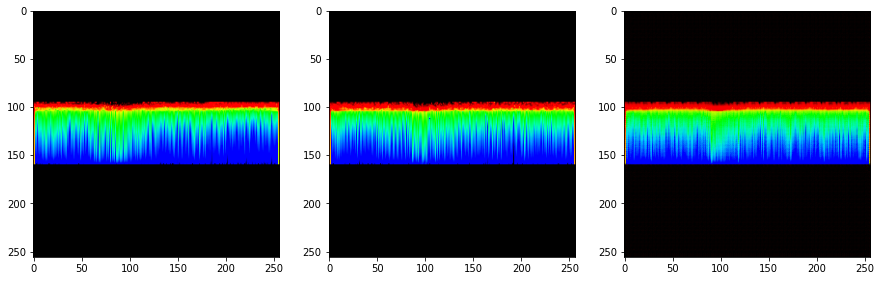

In [11]:
#Test an output

idx=50

im3d = ThreeDImages[idx]
im3d = load_image_train(im3d)
testing = np.expand_dims(im3d, axis=0)
model_test = generator.predict(testing)
model_test = np.squeeze(model_test)
print(model_test.shape)

im2d = TwoDImages[idx]
im2d = load_image_train(im2d)


fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(im3d)
ax[1].imshow(im2d)
ax[2].imshow(model_test)
plt.show()